# Introduction

A dataset containing 70 000 rows of health data has been cleaned and analysed and a logistic classifier was trained, in order to predict whether a given person might have a cardio-vascular disease or not. The source of the dataset was Kaggle.

There are 3 types of input features:

    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.

Features:

    Age | Objective Feature | age | int (days)
    Height | Objective Feature | height | int (cm) |
    Weight | Objective Feature | weight | float (kg) |
    Gender | Objective Feature | gender | categorical code | gender_map={1:'female',2:'male'}
    Systolic blood pressure | Examination Feature | ap_hi | int |
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    Smoking | Subjective Feature | smoke | binary |
    Alcohol intake | Subjective Feature | alco | binary |
    Physical activity | Subjective Feature | active | binary |
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 0 = no 1= yes

All of the dataset values had been collected at the moment of medical examination. 

By analysing the dataset and performing model selection and hyperparameter tuning, a classifier was derived.
The data was scaled using centering (i.e. StandardScaler) and the classifier used a regularized regressor with an elasticnet penalty found through hyperparameter optimization.

# EDA

To perform data analysis, the dataset was loaded as a pandas dataframe.
The dataset was well-balanced with respect to the target variable (cardio) and remained well-balanced after cleaning as well.

<Axes: xlabel='cardio', ylabel='count'>

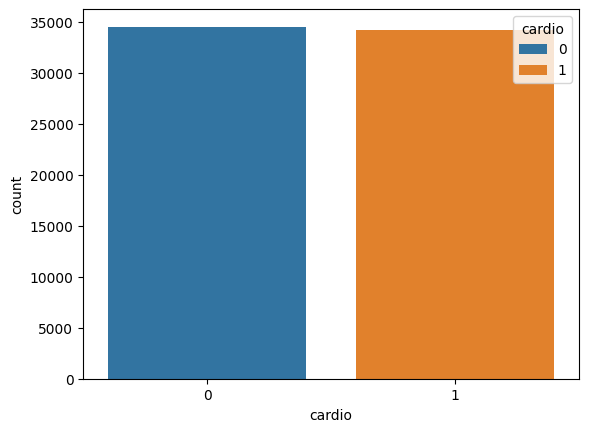

In [3]:
import pandas as pd
import seaborn as sns
df =  pd.read_csv("./Data/bmi_clean_cardio.csv", index_col= "id")
sns.countplot(df, x = "cardio", hue = "cardio")

In [5]:
print (f"{df.query('cholesterol == 1')['cholesterol'].count() / df['cholesterol'].count() * 100.:1f}% of people in the database have normal cholesterol")
print (f"{df.query('cholesterol == 2')['cholesterol'].count() / df['cholesterol'].count() * 100.:1f}% of people in the database have cholesterol above normal")
print (f"{df.query('cholesterol == 3')['cholesterol'].count() / df['cholesterol'].count() * 100.:1f}% of people in the database have cholesterol which is well above normal")

75.044044% of people in the database have normal cholesterol
13.529215% of people in the database have cholesterol above normal
11.426741% of people in the database have cholesterol which is well above normal


In [6]:
print (f"The average age is {int(df['age'].mean()/365)}, with the median {int(df['age'].median()/365)} and the mode 55")

The average age is 53, with the median 53 and the mode 55


In [7]:
print (f"{df.query('smoke == 1')['smoke'].count() / df['smoke'].count() * 100.:1f}% of people in the database are smokers")

8.823401% of people in the database are smokers


In [8]:
print (f"The procent of women having the cardiovascular disease in the dataset (to the total number of women) is {df.query('gender_2 == 0 and cardio ==1')['cardio'].count() / df.query('gender_2 == 0')['cardio'].count() * 100.:1f}%")
print (f"The procent of men having the cardiovascular disease in the dataset (to the total number of men) is {df.query('gender_2 == 1 and cardio ==1')['cardio'].count() / df.query('gender_2 == 1')['cardio'].count() * 100.:1f}%")
print (f"Overall procent of women in the dataset is {df.query('gender_2 == 0')['cardio'].count() / df['cardio'].count() * 100.:1f}%")

The procent of women having the cardiovascular disease in the dataset (to the total number of women) is 49.423301%
The procent of men having the cardiovascular disease in the dataset (to the total number of men) is 50.371108%
Overall procent of women in the dataset is 64.885485%


Concerning the correlations found:

- ap_hi / ap_lo (which are highly correlated themselves) to the target variable, with a higher influence of ap_hi (r = 0.44)
- cholesterol (0.22), and there is also an association (r = 0.45) between cholesterol and glucose levels.  
- added BMI feature has r = 0.19

Other factors seem to be insignificant, showing no correlation.

# Model selection

Two datasets were created from the original one, the first - categorial:
```python
df_categorial = df.drop(["ap_hi", "ap_lo", "height", "weight", "BMI", "ap_difference"], axis = 1)
df_categorial = pd.get_dummies(data = df_categorial, columns = ["gender", "BMI_categories", "blood pressure range"])
```
and the second one - with bmi column:
```python
df_bmi = df.drop(["BMI_categories", "blood pressure range", "height", "weight", "ap_difference"], axis = 1)
df_bmi = pd.get_dummies(data = df_bmi, columns=["gender"], drop_first=True)
```

For the final model training the df_bmi dataset has been used, as it showed a 1% better result.

For honest model training process, for both datasets:
- 100 final testing points were extracted;
- the remaining data, used as training data in final stage, was additionally split into training data and test data, with test size = 0.33

All the algorithms used were trained both on scaled and unscaled data for both datasets (with no significant difference in result).

For the training, the following algorithms were tried:
- Logistic Regression (with and without GridSearch)
- SVM (with and without GridSearch)
- Random Forest (with and without GridSearch)
- AdaBoost (without GridSearch)
- Naive Bayes (without GridSearch)
- KNN (with GridSearch)

All the models used to show the accuracy of 0.70 - 0.73, except for the Random Forest (without GridSearch) on categorial dataset, which resulted in 0.6. 

The reason for using Logistic Regression with GridSearch as a final model is that this is a relatively calculating cheap algorithm, while processing SVM+GridSearch with n_jobs = 4 on my laptop took >= 45 minutes for one run, and t

The final test on 100 datapoints, using all the rest of the dataset as a training data resulted in 0.79 accuracy.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

In [12]:
train_data =  pd.read_csv("./Data/train_bmi.csv", index_col= "id")
test_data =  pd.read_csv("./Data/test_samples.csv", index_col= "id")
X_final_test_b, y_final_test_b = test_data.drop("cardio", axis = 1), test_data["cardio"]

X_final_train_b, y_final_train_b = train_data.drop("cardio", axis = 1), train_data["cardio"]

scaler = StandardScaler()
pipe_log_reg = Pipeline([("scaler", scaler), ("log", LogisticRegression(solver = "saga", multi_class = "auto", 
                                                                        max_iter = 10000, penalty = "elasticnet"))])
l1_ratio = np.linspace(0, 1, 10)
param_grid_log_reg = {"log__l1_ratio": l1_ratio}
mymodel_lgr = GridSearchCV(estimator = pipe_log_reg, param_grid = param_grid_log_reg, 
                                  scoring = "balanced_accuracy", verbose = 5, n_jobs = 4)
mymodel_lgr.fit(X_final_train_b, y_final_train_b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=4,
             param_grid={'log__l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring='balanced_accuracy', verbose=5)

The best features after the run were:

In [13]:
print(mymodel_lgr.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log',
                 LogisticRegression(l1_ratio=0.4444444444444444, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])


# Results

A test run on 100 datapoints was performed.

In [14]:
yb_pred = mymodel_lgr.predict(X_final_test_b)
print(classification_report(y_final_test_b, yb_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78        49
           1       0.79      0.80      0.80        51

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



Accuracy: 0.790


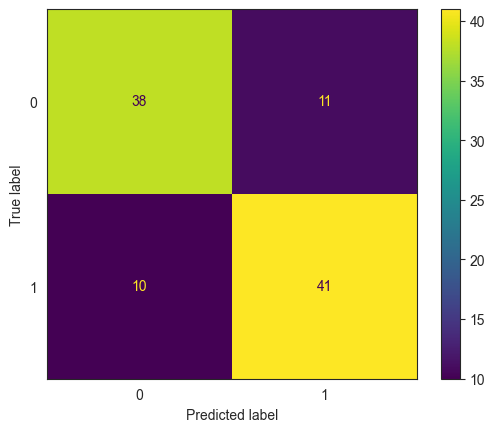

In [15]:
acc = accuracy_score (y_final_test_b, yb_pred)
print (f"Accuracy: {acc:.3f}")

sns.set_style('white')
cm = confusion_matrix (y_final_test_b, yb_pred, labels = mymodel_lgr.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels = mymodel_lgr.classes_)
disp.plot()

# Discussion

The classifier can probably perform better. Some other way of preprocessing information is probably needed, like deleting uncorrelated columns. Some additional hyperparameter tuning might also help, but a more powerful machine is needed to perform this, as even google colab wasn't of much help, and the more hyperparameters are tuned - the more hours are needed. A lot of hope was put into SVM with the following GridSearch:
```python
param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
    }
```
but it didn't work better then the final model, and there wasn't enough time to proceed that with kernel 'poly' even using n_jobs=20 (on a more powerful machine). So, I'm not sure any further hyperparameter tuning will help for LogRegr as well, and I would probably try some other way of data preprocessing.